# Modeling Attrition Prediction  
### Will Byrd June 2024  

## Introduction  

In this notebook, we will take a look at an HR Analytics dataset and perform a binary classification to determine Attrition.  Attrition is the departure of an employee from an organization fro any reason.  In this dataset we do not have context on why the emlpoyee leaves the company-they may have been fired or they may have resigned.  

For companies and orgnizations-the employees are the most important asset.  Therefore, it is vitally important to be able to predict behavior of these employees.  Knowing which employees will stay with the company can:  

* Reduce turnover costs  
  * Hiring and firing employees is expensive  
* Increase employee engagement and morale  
  * It can be difficult to maintain strong company culture if turnover is high  
* Assist with resource planning  
  * Companies can add resources to employees they believe will contribute to longterm growth
  * Conversely, companies can take proactive measures to retain at risk employees
* Improve customer relationships  
  * Customer percieve companies that retain talent more positively
* Enhance company reputation  
  * Company brand is often times tied to the employees interacting with the customers


## Data  

HR Analytics data was collected [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).  This is a 228 kB, publicly available csv file with 1479 rows and 35 columns from Kaggle.  Important features are going to be our target value **'Attrition'**, and various features such as:  

* Job Satisfaction
* Age
* Sex
* Job Title
* Salary  

### Data Preperation  

This dataset is already cleaned, but some processing still needs to occur.  We will need to:  

* Engineer Features  
  * Combining, Transforming columns
  * Label Encoding, One-Hot Encoding categorical features
* Dropping Columns  
* Balancing Classes  
  * The class imblance issue will be a limitation of this dataset and a tradeoff between overall accuracy and Recall will happen  

### Goals  

The main goal of our model is to maximize **accuracy**.  Accuracy will be important here as being able to accurately predict which employees will stay and which will leave is important.  It's also important to understand that since we don't know if employees are fired and which ones quit, simply targeting the positive Attrition class (Recall) will still not tell the entire story.  

Here are the metrics we will be looking at for this business case:  

* Accuracy-Overall accuracy of our model  

* Precision-Accuracy of positive predictions made by our model  
  * High Precision indicates that an employee will leave, it is usually correct.  **High Precision minimizes false positives.**    

* Recall-The ability of our model to identify the actual positive observations  
  * High Recall is going to be tough with this dataset specifically since we are battling a class imbalance issue.  As we will see in our dataset, nearly 15% of our data is the positive **Attrition** class.  
  
* F1-Score that factors in both Precision and Recall

In [ ]:
#importing packages to read in data from Kaggle host site
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# api key for the json object below
api_key = userdata.get('API_KEY')

# using pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opening file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
import kaggle
! kaggle dataset download faressayah/ibm-hr-analytics-employee-attrition-performance/input

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('hr_data.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [5]:
df = df.drop(columns=[
    'Over18',
    'EmployeeCount',
    'StandardHours',
    'EmployeeNumber'
    
])

In [6]:
df['YearsInCurrentRole_vs_YearsAtCompany'] = df['YearsInCurrentRole'] / df['YearsAtCompany']


In [7]:
# Create the new feature with division
df['YearsInCurrentRole_vs_YearsAtCompany'] = df['YearsInCurrentRole'] / df['YearsAtCompany']

# Replace NaN values with 0
df['YearsInCurrentRole_vs_YearsAtCompany'].fillna(0, inplace=True)

# Verify changes
print(df[['YearsInCurrentRole', 'YearsAtCompany', 'YearsInCurrentRole_vs_YearsAtCompany']].head())


   YearsInCurrentRole  YearsAtCompany  YearsInCurrentRole_vs_YearsAtCompany
0                   4               6                              0.666667
1                   7              10                              0.700000
2                   0               0                              0.000000
3                   7               8                              0.875000
4                   2               2                              1.000000


In [8]:
df['TotalYearsCurrentJob'] = df['YearsInCurrentRole'] + df['YearsWithCurrManager']


In [9]:
df['FrequentBusinessTravel'] = df['BusinessTravel'].apply(lambda x: 1 if x == 'Travel_Frequently' else 0)


In [10]:
df['JobEnvSatisfaction'] = df['JobSatisfaction'] + df['EnvironmentSatisfaction']


In [11]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsInCurrentRole_vs_YearsAtCompany,TotalYearsCurrentJob,FrequentBusinessTravel,JobEnvSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,0,1,6,4,0,5,0.666667,9,0,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,3,3,10,7,1,7,0.700000,14,1,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,3,0,0,0,0,0.000000,0,0,7
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,8,7,3,0,0.875000,7,1,7
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,3,2,2,2,2,1.000000,4,0,3


In [12]:
df['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

* EDA
* Create some visualizations based on data     
* Try only oversampling to preserve data  
* Feature Engineering  
  * Scaling
  * Combining
  * Transform
  * Creating extra columns
* Outlier Detection  
* Correlation   

Models to build  

* Decision Tree Classifier
* KNN

In [13]:
att_age_group = df.groupby(['Attrition', 'Age'])
group_sizes = att_age_group.size()
print(group_sizes)


Attrition  Age
No         18      4
           19      3
           20      5
           21      7
           22     11
                  ..
Yes        52      3
           53      2
           55      3
           56      3
           58      5
Length: 82, dtype: int64


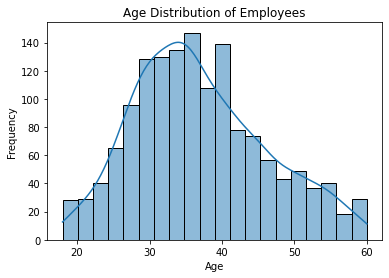

In [14]:
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Employees')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

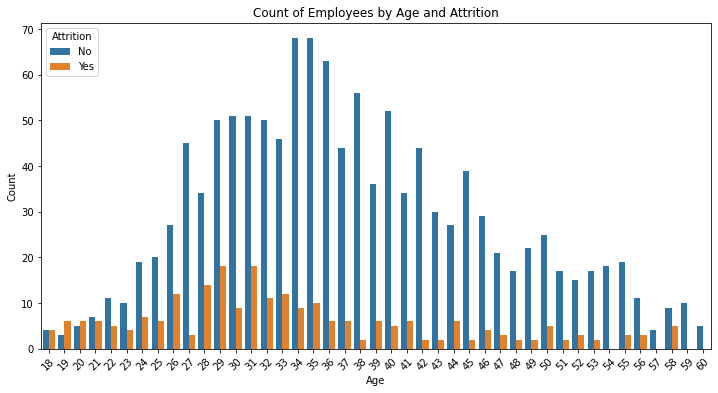

In [15]:
# Convert group_sizes to DataFrame for easier manipulation
group_sizes_df = group_sizes.reset_index(name='Count')

# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(data=group_sizes_df, x='Age', y='Count', hue='Attrition')
plt.title('Count of Employees by Age and Attrition')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
att_gen_group = df.groupby(['Attrition', 'Gender'])
att_gen_group = att_gen_group.size()
print(att_gen_group)


Attrition  Gender
No         Female    501
           Male      732
Yes        Female     87
           Male      150
dtype: int64


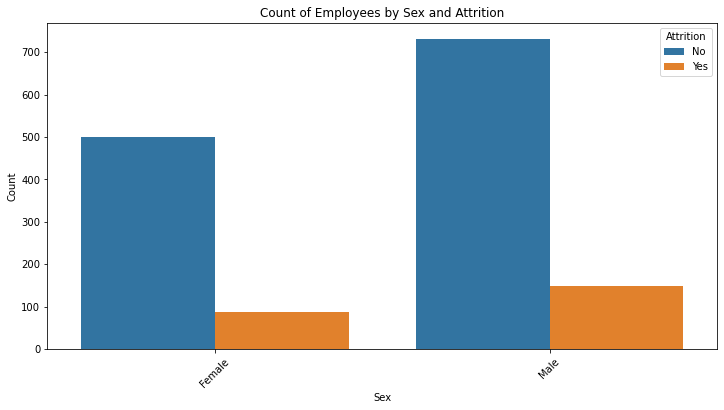

In [17]:
# Convert group_sizes to DataFrame for easier manipulation
att_gen_df = att_gen_group.reset_index(name='Count')

# Plotting the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(data=att_gen_df, x='Gender', y='Count', hue='Attrition')
plt.title('Count of Employees by Sex and Attrition')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

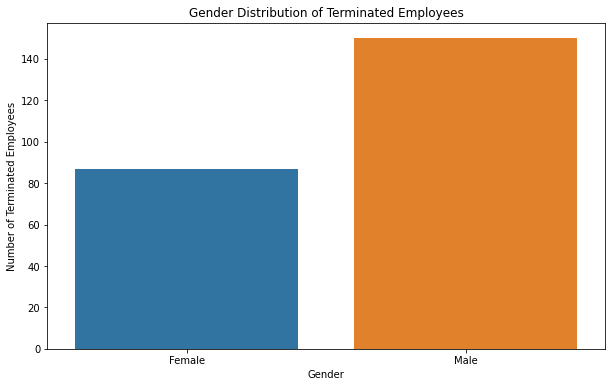

In [18]:
terminated_df = df[df['Attrition'] == 'Yes']

# Plot the gender distribution of terminated employees
plt.figure(figsize=(10, 6))
sns.countplot(data=terminated_df, x='Gender')
plt.title('Gender Distribution of Terminated Employees')
plt.xlabel('Gender')
plt.ylabel('Number of Terminated Employees')
plt.show()

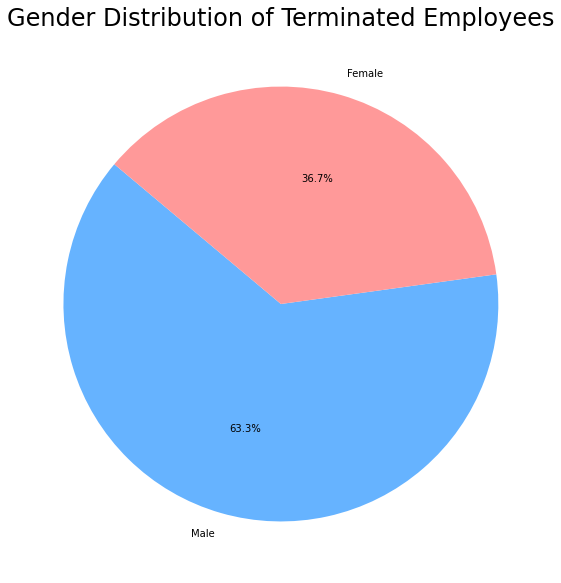

In [19]:
# Calculate the distribution of genders
gender_counts = terminated_df['Gender'].value_counts()

# Plot the gender distribution of terminated employees as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Gender Distribution of Terminated Employees', fontsize=24)

# Show the plot
plt.show()

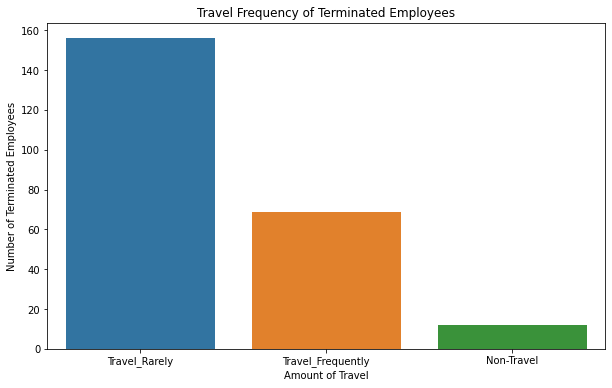

In [20]:
terminated_df = df[df['Attrition'] == 'Yes']

# Plot the gender distribution of terminated employees
plt.figure(figsize=(10, 6))
sns.countplot(data=terminated_df, x='BusinessTravel')
plt.title('Travel Frequency of Terminated Employees')
plt.xlabel('Amount of Travel')
plt.ylabel('Number of Terminated Employees')
plt.show()

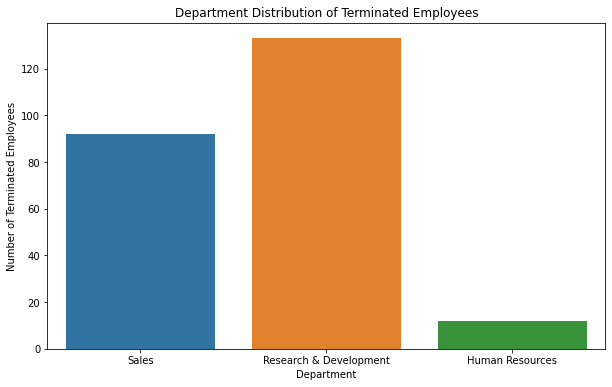

In [21]:
terminated_df = df[df['Attrition'] == 'Yes']

# Plot the gender distribution of terminated employees
plt.figure(figsize=(10, 6))
sns.countplot(data=terminated_df, x='Department')
plt.title('Department Distribution of Terminated Employees')
plt.xlabel('Department')
plt.ylabel('Number of Terminated Employees')
plt.show()

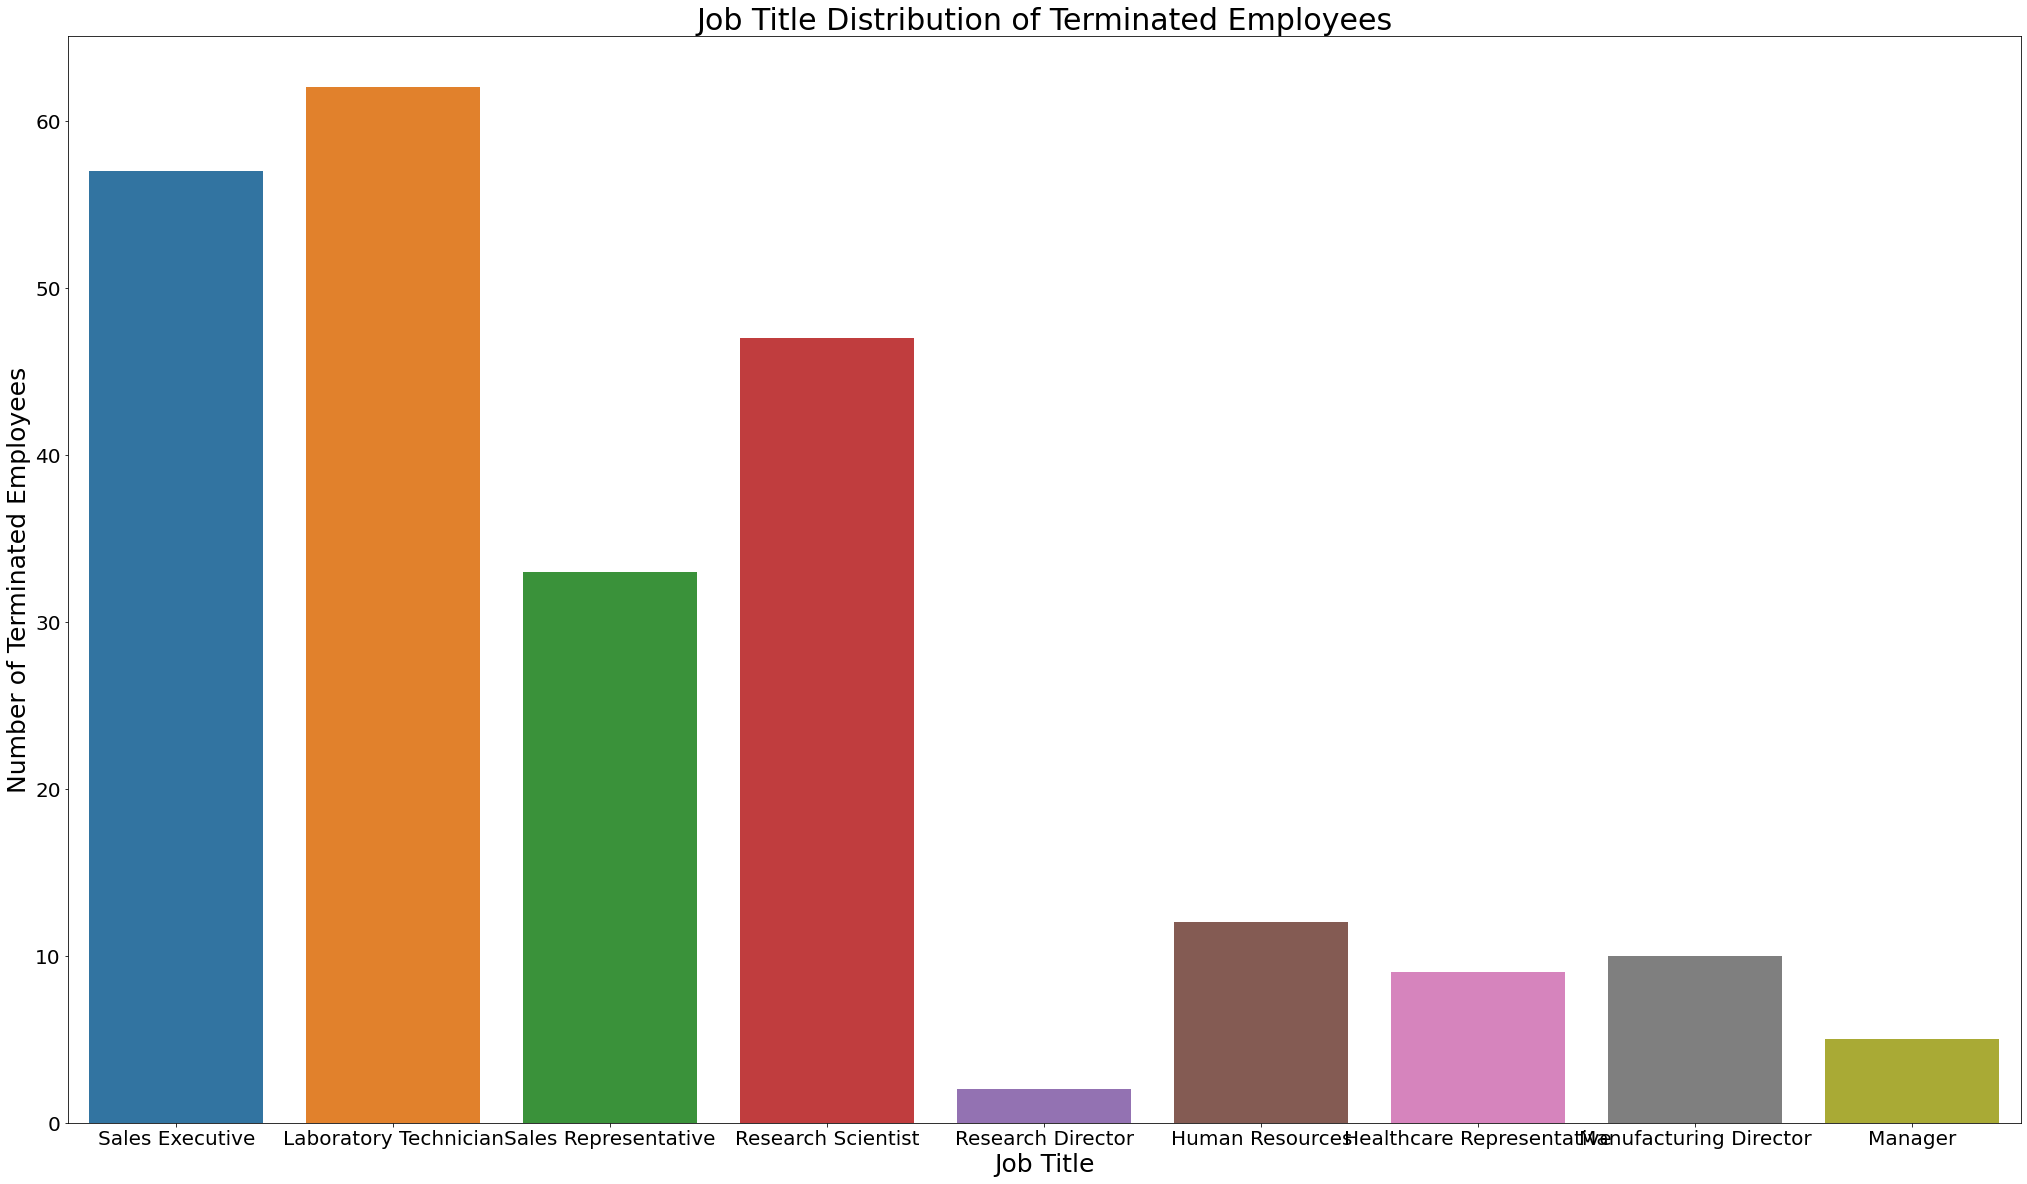

In [22]:


# Plot the gender distribution of terminated employees
plt.figure(figsize=(35, 20))
sns.countplot(data=terminated_df, x='JobRole')
plt.title('Job Title Distribution of Terminated Employees', fontsize=30)
plt.xlabel('Job Title', fontsize=25)
plt.ylabel('Number of Terminated Employees', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

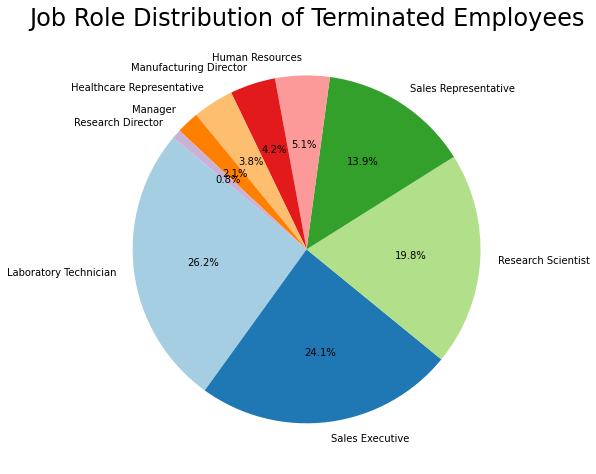

In [23]:
# Calculate the distribution of job roles
jobrole_counts = terminated_df['JobRole'].value_counts()

# Plot the job role distribution of terminated employees as a pie chart
plt.figure(figsize=(12, 8))
plt.pie(jobrole_counts, labels=jobrole_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Job Role Distribution of Terminated Employees', fontsize=24)

# Show the plot
plt.show()

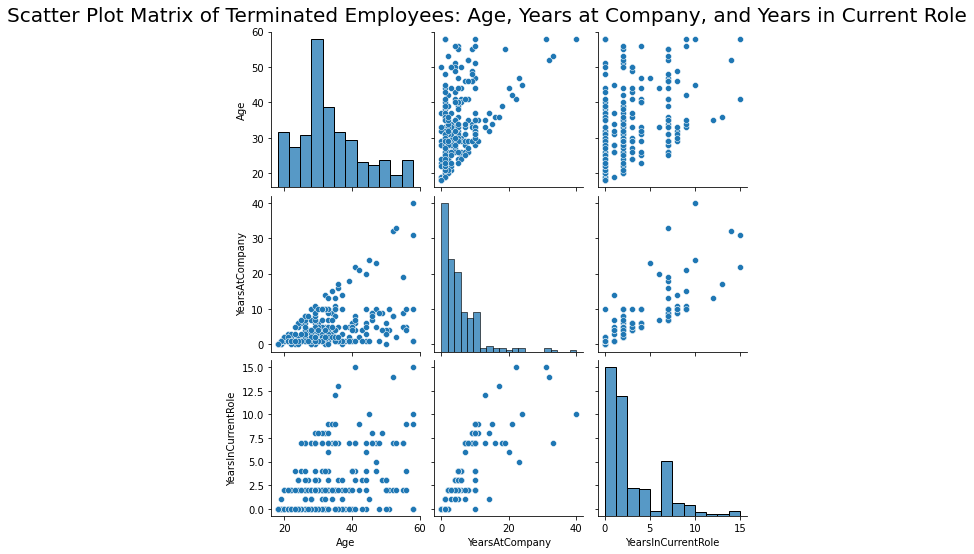

In [24]:
# Plot using pairplot
sns.pairplot(terminated_df[['Age', 'YearsAtCompany', 'YearsInCurrentRole']])
plt.suptitle('Scatter Plot Matrix of Terminated Employees: Age, Years at Company, and Years in Current Role', y=1.02, fontsize=20)
plt.show()

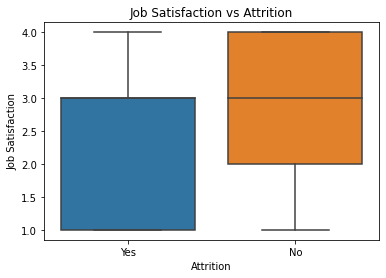

In [25]:
sns.boxplot(data=df, x='Attrition', y='JobSatisfaction')
plt.title('Job Satisfaction vs Attrition')
plt.xlabel('Attrition')
plt.ylabel('Job Satisfaction')
plt.show()

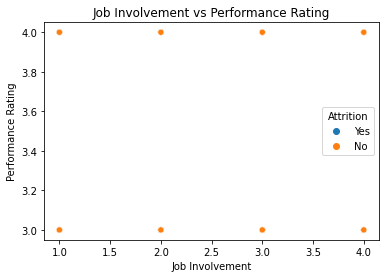

In [26]:
sns.scatterplot(data=df, x='JobInvolvement', y='PerformanceRating', hue='Attrition')
plt.title('Job Involvement vs Performance Rating')
plt.xlabel('Job Involvement')
plt.ylabel('Performance Rating')
plt.show()

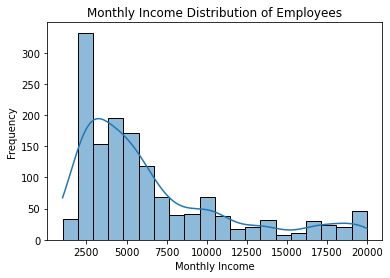

In [27]:
sns.histplot(df['MonthlyIncome'], bins=20, kde=True)
plt.title('Monthly Income Distribution of Employees')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.show()

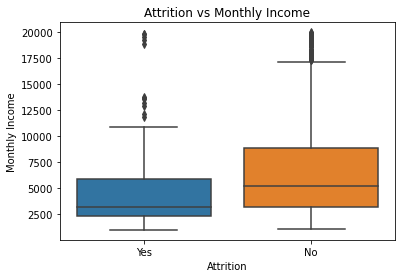

In [28]:
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome')
plt.title('Attrition vs Monthly Income')
plt.xlabel('Attrition')
plt.ylabel('Monthly Income')
plt.show()

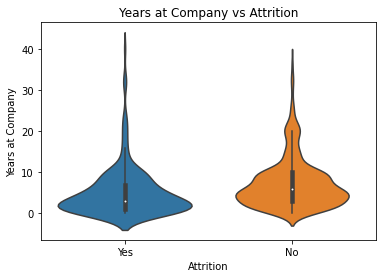

In [29]:
sns.violinplot(data=df, x='Attrition', y='YearsAtCompany')
plt.title('Years at Company vs Attrition')
plt.xlabel('Attrition')
plt.ylabel('Years at Company')
plt.show()

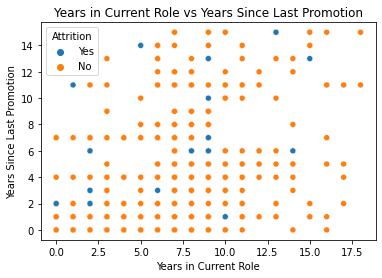

In [30]:
sns.scatterplot(data=df, x='YearsInCurrentRole', y='YearsSinceLastPromotion', hue='Attrition')
plt.title('Years in Current Role vs Years Since Last Promotion')
plt.xlabel('Years in Current Role')
plt.ylabel('Years Since Last Promotion')
plt.show()

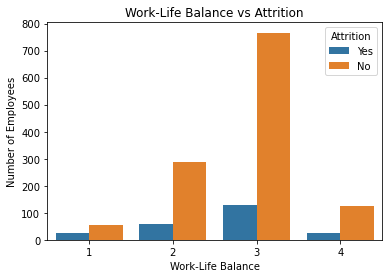

In [31]:
sns.countplot(data=df, x='WorkLifeBalance', hue='Attrition')
plt.title('Work-Life Balance vs Attrition')
plt.xlabel('Work-Life Balance')
plt.ylabel('Number of Employees')
plt.show()

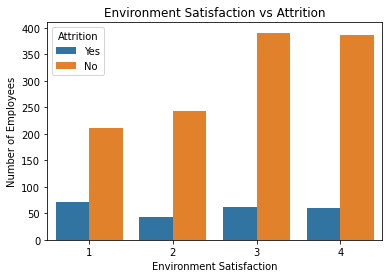

In [32]:
sns.countplot(data=df, x='EnvironmentSatisfaction', hue='Attrition')
plt.title('Environment Satisfaction vs Attrition')
plt.xlabel('Environment Satisfaction')
plt.ylabel('Number of Employees')
plt.show()

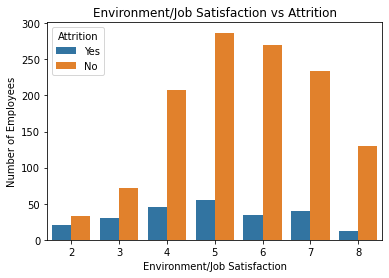

In [33]:
sns.countplot(data=df, x='JobEnvSatisfaction', hue='Attrition')
plt.title('Environment/Job Satisfaction vs Attrition')
plt.xlabel('Environment/Job Satisfaction')
plt.ylabel('Number of Employees')
plt.show()


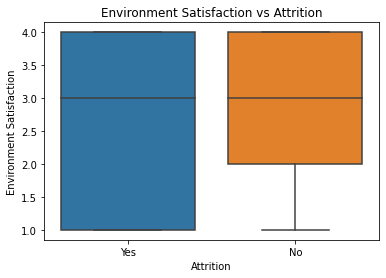

In [34]:
sns.boxplot(data=df, x='Attrition', y='EnvironmentSatisfaction')
plt.title('Environment Satisfaction vs Attrition')
plt.xlabel('Attrition')
plt.ylabel('Environment Satisfaction')
plt.show()

In [35]:
# Convert target variable to binary
#df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Step 1: Identify columns to be transformed into dummy variables
#dummy_col = [column for column in df.drop('Attrition', axis=1).columns if df[column].nunique() < 25]

# Step 2: Apply pd.get_dummies to transform categorical columns into dummy variables
#df = pd.get_dummies(df, columns=dummy_col, drop_first=True, dtype='uint8')

In [36]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsInCurrentRole_vs_YearsAtCompany,TotalYearsCurrentJob,FrequentBusinessTravel,JobEnvSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,0,1,6,4,0,5,0.666667,9,0,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,3,3,10,7,1,7,0.700000,14,1,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,3,0,0,0,0,0.000000,0,0,7
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,8,7,3,0,0.875000,7,1,7
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,3,2,2,2,2,1.000000,4,0,3


In [37]:
# Convert 'Attrition' column to binary
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Identify categorical columns (excluding 'Attrition')
cat_cols = [column for column in df.columns if df[column].nunique() < 15 and df[column].dtype == 'object' and column != 'Attrition']

# Apply pd.get_dummies only to categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='uint8')

# Display the transformed DataFrame
print("\nTransformed DataFrame:")
print(df)


Transformed DataFrame:
      Age  Attrition  DailyRate  DistanceFromHome  Education  \
0      41          1       1102                 1          2   
1      49          0        279                 8          1   
2      37          1       1373                 2          2   
3      33          0       1392                 3          4   
4      27          0        591                 2          1   
...   ...        ...        ...               ...        ...   
1465   36          0        884                23          2   
1466   39          0        613                 6          1   
1467   27          0        155                 4          3   
1468   49          0       1023                 2          3   
1469   34          0        628                 8          3   

      EnvironmentSatisfaction  HourlyRate  JobInvolvement  JobLevel  \
0                           2          94               3         2   
1                           3          61               2        

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   1470 non-null   int64  
 1   Attrition                             1470 non-null   int64  
 2   DailyRate                             1470 non-null   int64  
 3   DistanceFromHome                      1470 non-null   int64  
 4   Education                             1470 non-null   int64  
 5   EnvironmentSatisfaction               1470 non-null   int64  
 6   HourlyRate                            1470 non-null   int64  
 7   JobInvolvement                        1470 non-null   int64  
 8   JobLevel                              1470 non-null   int64  
 9   JobSatisfaction                       1470 non-null   int64  
 10  MonthlyIncome                         1470 non-null   int64  
 11  MonthlyRate      

In [39]:
df.corr()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
Age,1.000000,-0.159205,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,-0.004892,...,-0.143176,0.294248,0.049726,0.185891,-0.146518,-0.002001,-0.175785,0.083919,-0.119185,0.028062
Attrition,-0.159205,1.000000,-0.056652,0.077924,-0.031373,-0.103369,-0.006846,-0.130016,-0.169105,-0.103481,...,0.098290,-0.083316,-0.082994,-0.088870,-0.000360,0.019774,0.157234,-0.090984,0.175419,0.246118
DailyRate,0.010661,-0.056652,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,0.030571,...,-0.006728,-0.013224,-0.005302,-0.000021,-0.002624,-0.000513,0.005375,0.040035,-0.075835,0.009135
DistanceFromHome,-0.001686,0.077924,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,-0.003669,...,0.012369,-0.039190,0.011848,-0.022351,-0.010986,0.030761,-0.015994,0.030232,-0.027445,0.025514
Education,0.208034,-0.031373,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,-0.011296,...,-0.063566,0.028453,-0.005290,0.049694,0.000709,0.053398,-0.091465,-0.001865,0.004168,-0.020322
EnvironmentSatisfaction,0.010146,-0.103369,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,-0.006784,...,-0.001533,0.010730,0.059178,-0.048689,0.001940,-0.024421,0.002949,-0.022180,0.009035,0.070132
HourlyRate,0.024287,-0.006846,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,-0.071335,...,0.018028,0.012659,-0.014394,-0.025128,0.020034,-0.011886,-0.018703,0.036432,-0.033436,-0.007782
JobInvolvement,0.029820,-0.130016,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,-0.021476,...,-0.022724,0.017112,-0.021939,0.015200,0.047604,-0.011413,-0.027282,0.028324,-0.045253,-0.003507
JobLevel,0.509604,-0.169105,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,-0.001944,...,-0.344608,0.552744,0.114896,0.414319,-0.387788,0.127490,-0.216559,0.050547,-0.087072,0.000544
JobSatisfaction,-0.004892,-0.103481,0.030571,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,...,-0.015710,-0.005620,-0.013747,-0.006217,0.020503,0.012604,0.001413,-0.010315,0.024571,0.024539


<AxesSubplot:>

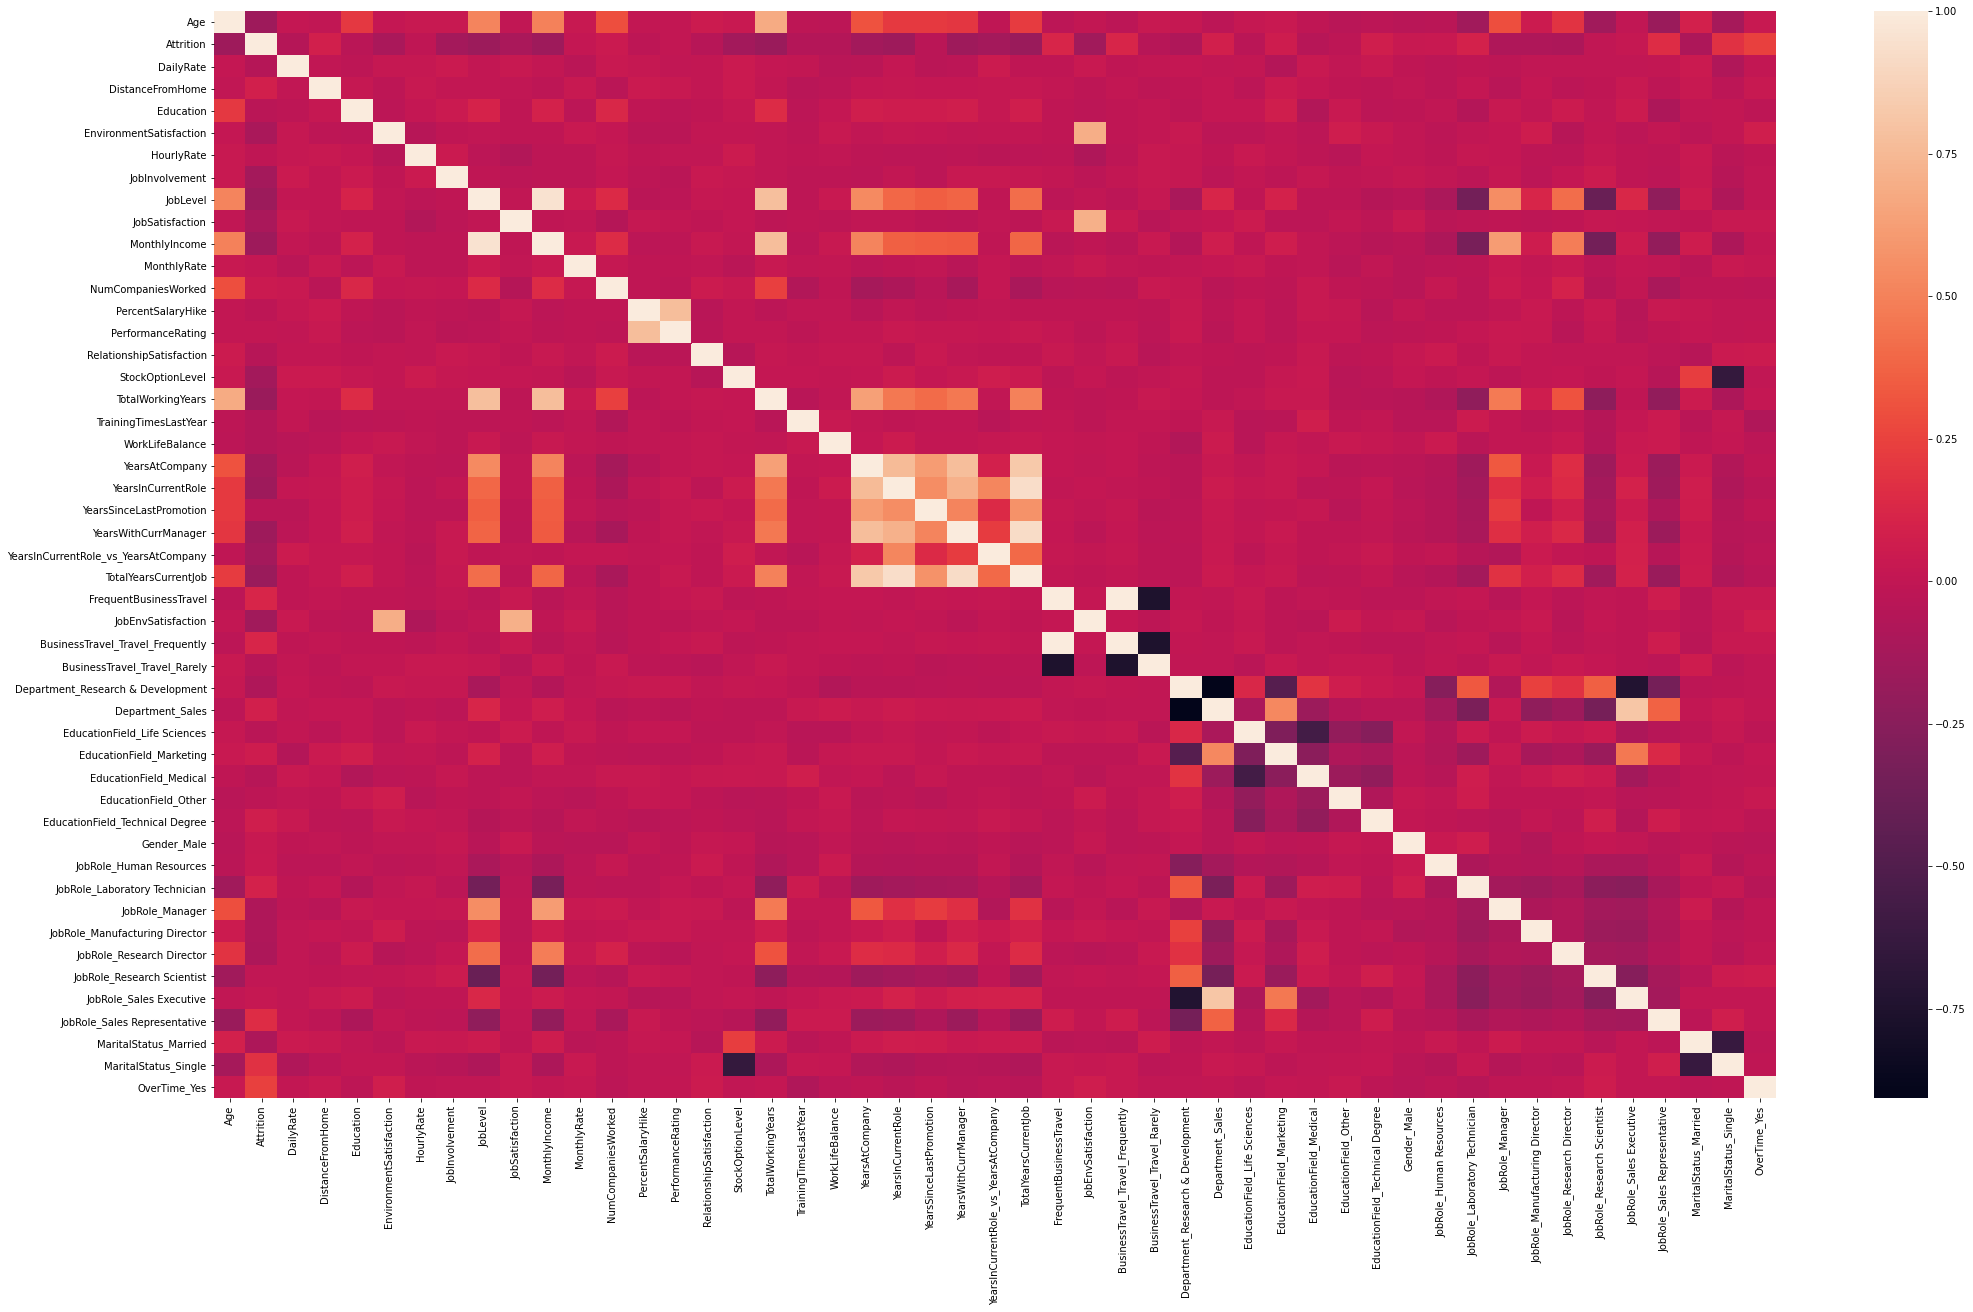

In [40]:
plt.figure(figsize=(35,20))
sns.heatmap(df.corr())

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)

In [42]:
#def feature_imp(df, model):
#    fi = pd.DataFrame()
#    fi["feature"] = df.columns
#    fi["importance"] = model.feature_importances_
#    return fi.sort_values(by="importance", ascending=False)

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

In [44]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear', penalty='l1')
lr_clf.fit(X_train_std, y_train)

evaluate(lr_clf, X_train_std, X_test_std, y_train, y_test)

CONFUSION MATRIX:
[[237  10]
 [ 31  16]]
ACCURACY SCORE:
0.8605
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.884328   0.615385  0.860544    0.749856      0.841334
recall       0.959514   0.340426  0.860544    0.649970      0.860544
f1-score     0.920388   0.438356  0.860544    0.679372      0.843329
support    247.000000  47.000000  0.860544  294.000000    294.000000


In [45]:
# Initialize your model (e.g., RandomForestClassifier)
model = RandomForestClassifier(n_estimators=100, bootstrap=False)

# Train the model
model.fit(X_train, y_train)

# Predictions on test set
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
print(f"CLASSIFICATION REPORT:\n{clf_report}")


# Evaluation metrics
#print("TESTING RESULTS: \n===============================")
#print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
#print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
#print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")

CONFUSION MATRIX:
[[241   6]
 [ 40   7]]
ACCURACY SCORE:
0.8435
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.857651   0.538462  0.843537    0.698056      0.806624
recall       0.975709   0.148936  0.843537    0.562322      0.843537
f1-score     0.912879   0.233333  0.843537    0.573106      0.804244
support    247.000000  47.000000  0.843537  294.000000    294.000000


In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, bootstrap=False,
#                                      class_weight={0:stay, 1:leave}
                                    )
rf_clf.fit(X_train, y_train)
evaluate(rf_clf, X_train, X_test, y_train, y_test)

CONFUSION MATRIX:
[[239   8]
 [ 40   7]]
ACCURACY SCORE:
0.8367
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.856631   0.466667  0.836735    0.661649      0.794290
recall       0.967611   0.148936  0.836735    0.558274      0.836735
f1-score     0.908745   0.225806  0.836735    0.567276      0.799568
support    247.000000  47.000000  0.836735  294.000000    294.000000


In [47]:
df_final.isna().sum()

NameError: name 'df_final' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select numeric columns to scale
numeric_columns = df_final.select_dtypes(include=['int64', 'float64']).columns

# Apply the scaler to the numeric columns
df_final[numeric_columns] = scaler.fit_transform(df_final[numeric_columns])

In [ ]:
# Seperate target and features
X = df_final.drop('Attrition', axis=1) # all columns except the target column our our independent variables
y = df_final['Attrition']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['Attrition'])

In [ ]:
# Print the shapes of the resulting DataFrames
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
# Check the class distribution in y_train and y_test
print("Class distribution in y_train:\n", y_train.value_counts())
print("Class distribution in y_test:\n", y_test.value_counts())

In [ ]:
# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=.75, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply RandomUnderSampler to the training data
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced.shape}")
print(f"y_train shape after resampling: {y_train_balanced.shape}")

In [ ]:
clf_balanced_tree =DecisionTreeClassifier(random_state=42)
clf_balanced_tree.fit(X_train_balanced, y_train_balanced)

y_pred = clf_balanced_tree.predict(X_test)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_balanced_tree.classes_).plot()
plt.show()

In [ ]:
# Get feature importances
feature_importances = clf_balanced_tree.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.bar(range(X_train_balanced.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train_balanced.shape[1]), X_train_balanced.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]  # Adjusted to put more emphasis on class '1'
}

# Initialize the classifier
clf_balanced_treecv = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_balanced_treecv, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()



In [ ]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]  # Adjusted to put more emphasis on class '1'
}

# Initialize the classifier
clf_balanced_tree = DecisionTreeClassifier(random_state=42)

# Create a scorer for F2 score
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_balanced_tree, param_grid=param_grid, cv=5, scoring=f2_scorer, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()


# Most Accurate Model

In [ ]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_rf.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf_rf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming clf_balanced_tree, clf_balanced_treecv, and clf_rf are already trained

# Initialize the Voting Classifier with your existing models
voting_clf = VotingClassifier(estimators=[
    ('baseline', clf_balanced_tree),
    ('finetuned', clf_balanced_treecv),
    ('random_forest', clf_rf)
], voting='soft')

# Fit the Voting Classifier
voting_clf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

print("\nConfusion Matrix:")
cm_voting = confusion_matrix(y_test, y_pred_voting)
print(cm_voting)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=voting_clf.classes_).plot()
plt.show()



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Assuming clf_balanced_tree, clf_balanced_treecv, and clf_rf are already trained

# Initialize the Voting Classifier with adjusted class weights and hyperparameter tuning
voting_clf = VotingClassifier(estimators=[
    ('baseline', clf_balanced_tree),
    ('finetuned', clf_balanced_treecv),
    ('random_forest', clf_rf)
], voting='soft')

# Define the parameter grid for GridSearchCV
param_grid = {
    'voting': ['soft'],
    'weights': [[1, 1, 1], [1, 2, 1], [1, 1, 2], [1, 3, 1], [1, 1, 3]],  # Adjust weights to emphasize class '1'
    'flatten_transform': [True, False]
}
from sklearn.metrics import make_scorer, recall_score

# Define a custom scoring function emphasizing recall for class '1'
custom_scorer = make_scorer(recall_score, pos_label=1)

# Initialize GridSearchCV with the custom scorer
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_).plot()
plt.show()


In [ ]:
df_final = df_final.drop(columns=[
    'JobRole_Sales Executive',
    'MaritalStatus_Married',
    'YearsInCurrentRole',
    'EducationField_Life Sciences',
    'RelationshipSatisfaction',
    'PerformanceRating',
    'EducationField_Other',
    'JobSatisfaction',
    'OverTime',
    'FrequentBusinessTravel',
    'BusinessTravel',
    'JobRole_Research Director',
    'JobRole_Manager',
    'JobRole_Manufacturing Director'
])

In [ ]:
# Seperate target and features
X = df_final.drop('Attrition', axis=1) # all columns except the target column our our independent variables
y = df_final['Attrition']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['Attrition'])

In [ ]:
# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=.75, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply RandomUnderSampler to the training data
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train_smote, y_train_smote)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced.shape}")
print(f"y_train shape after resampling: {y_train_balanced.shape}")

In [ ]:
clf =DecisionTreeClassifier(random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

y_pred = clf.predict(X_test)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()
plt.show()

In [ ]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Tips to Improve Models  
* GridsearchCV
* Play around with SMOTE
* Remove Unimportant Features
* Ensemble on model maxxed on 'yes' and 'no'
* Receiver Operater Characteristic Curve (ROC)- Area Under the Curve (AUC)
* CV Scores

In [ ]:
len(y_train_balanced)

In [ ]:
len(y_train)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot box plots for each numeric column
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(6, 5, i)  # Adjust the layout based on the number of columns
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

# Adjust the IQR threshold
threshold = 3.0  # Example: use a higher threshold to identify fewer outliers

# Identify outliers using the IQR method
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - threshold * IQR)) | (df[numeric_cols] > (Q3 + threshold * IQR))).any(axis=1)
print(f'Number of outliers: {outliers.sum()}')

# Remove outliers
df_clean = df[~outliers]

# Check the shape of the dataset before and after removing outliers
print(f'Original dataset shape: {df.shape}')
print(f'Cleaned dataset shape: {df_clean.shape}')


In [ ]:
label_encoder = LabelEncoder()

columns_to_encode = [
    'BusinessTravel',
    'OverTime',
    'Attrition'
]

for column in columns_to_encode:
    df_clean.loc[:, column] = label_encoder.fit_transform(df_clean[column])

# Print df_clean to verify the encoding
df_clean.head()

In [ ]:
columns_to_encode = ['Department',
                    'EducationField',
                    'Gender',
                    'JobRole',
                    'MaritalStatus']

# Create an instance of OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the data
encoded_data = ohe.fit_transform(df_clean[columns_to_encode])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(columns_to_encode))

# Drop the original columns and concatenate the encoded columns
df_encoded = df_clean.drop(columns_to_encode, axis=1).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
df_cleaned = pd.concat([df_encoded, encoded_df], axis=1)

# Display the DataFrame
df_cleaned

In [ ]:
# Separate target and features
X = df_cleaned.drop('Attrition', axis=1)  # Check df_clean to ensure it's correctly prepared
y = df_cleaned['Attrition']

# Check shapes
print(X.shape)  # Should match the number of rows in df_clean minus 1 (for dropped column)
print(y.shape)  # Should match the number of rows in df_clean

# Split the data into train and test sets
#from sklearn.model_selection import train_test_split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


In [ ]:
# Print the shapes of the resulting DataFrames
print(f"X_train shape: {X_train_clean.shape}")
print(f"X_test shape: {X_test_clean.shape}")
print(f"y_train shape: {y_train_clean.shape}")
print(f"y_test shape: {y_test_clean.shape}")

In [ ]:
# Check the class distribution in y_train and y_test
print("Class distribution in y_train:\n", y_train_clean.value_counts())
print("Class distribution in y_test:\n", y_test_clean.value_counts())

In [ ]:
# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust sampling_strategy as needed
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42, replacement=False)  # Adjust sampling_strategy as needed

# Apply SMOTE to the training data
X_train_smote_clean, y_train_smote_clean = smote.fit_resample(X_train_clean, y_train_clean)

# Apply RandomUnderSampler to the training data
X_train_balanced_clean, y_train_balanced_clean = under_sampler.fit_resample(X_train_smote_clean, y_train_smote_clean)
# Print the class distribution after resampling
print("Class distribution before resampling:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

print("\nClass distribution after SMOTE and undersampling:")
print(y_train_balanced.value_counts())

# Print the shapes of the resulting DataFrames
print(f"\nX_train shape after resampling: {X_train_balanced_clean.shape}")
print(f"y_train shape after resampling: {y_train_balanced_clean.shape}")

In [ ]:
clf_clean =DecisionTreeClassifier(random_state=42)
clf_clean.fit(X_train_balanced_clean, y_train_balanced_clean)

y_pred_clean = clf_clean.predict(X_test_clean)


# Evaluate the classifier
print("\nAccuracy Score:")
print(accuracy_score(y_test_clean, y_pred_clean))
print("\nClassification Report:")
print(classification_report(y_test_clean, y_pred_clean))

print("\nAccuracy Score:")
print(accuracy_score(y_test_clean, y_pred_clean))

print("\nConfusion Matrix:")
cm_clean_tree = confusion_matrix(y_test_clean, y_pred_clean)
print(cm_clean_tree)

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_clean_tree, display_labels=clf_clean.classes_).plot()
plt.show()

In [ ]:
# Example of using SMOTE for oversampling and adjusting class weights
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train your classifier, adjusting class weights if needed
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()